In [1]:
from skimage.segmentation import watershed, felzenszwalb
from skimage.filters import sobel
import pandas as pd
from pathlib import Path
import cv2
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.filters import rank
from scipy import ndimage as ndi
from skimage.morphology import disk
import sklearn.metrics

In [2]:
# downloading the images

!wget https://challengedata.ens.fr/media/public/train-images.zip
!wget https://challengedata.ens.fr/media/public/test-images.zip
!wget https://challengedata.ens.fr/media/public/label_Hnl61pT.csv -O y_train.csv
!unzip train-images.zip
!unzip test-images.zip

--2025-03-11 16:59:19--  https://challengedata.ens.fr/media/public/train-images.zip
Resolving challengedata.ens.fr (challengedata.ens.fr)... 129.199.99.148
Connecting to challengedata.ens.fr (challengedata.ens.fr)|129.199.99.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52391647 (50M) [application/zip]
Saving to: ‘train-images.zip’

train-images.zip    100%[===================>]  49.96M  14.2MB/s    in 3.9s    

2025-03-11 16:59:24 (12.9 MB/s) - ‘train-images.zip’ saved [52391647/52391647]

--2025-03-11 16:59:24--  https://challengedata.ens.fr/media/public/test-images.zip
Resolving challengedata.ens.fr (challengedata.ens.fr)... 129.199.99.148
Connecting to challengedata.ens.fr (challengedata.ens.fr)|129.199.99.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12803342 (12M) [application/zip]
Saving to: ‘test-images.zip’

test-images.zip     100%[===================>]  12.21M  7.09MB/s    in 1.7s    

2025-03-11 16:59:27 (7.09 

In [3]:
# Load the train labels
# Note the transpose!
labels_train = pd.read_csv("y_train.csv", index_col=0).T
# Here is a function to load the data
def load_dataset(dataset_dir):
    dataset_list = []
    # Note: It's very important to load the images in the correct numerical order!
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

# Load the train and test sets
# If you've put the shortcut directly in your drive, this should work out of the box
# Else, edit the path
data_dir = Path("./")
data_train = load_dataset(data_dir / "train-images")
data_test = load_dataset(data_dir / "test-images")

# Handling the data

In [4]:
# # Load the train labels
# # Note the transpose!
# labels_train = pd.read_csv("y_train.csv", index_col=0).T

In [5]:
#Change it with what you need
#For the training with only images or images and features i took data_train_1 = [:700] and data_train_2 = [700:800] for validation

data_train_1 = data_train[:350]
unlabeled_train_data = data_train[800:]
label_train_1 = labels_train[:350]
unlabeled_train_labels = labels_train[800:]

data_train_2 = data_train[350:700]
label_train_2 = labels_train.iloc[350:700]

data_val = data_train[700:800]
label_val = labels_train.iloc[700:800]

In [6]:
# The train data is a numpy array of 1000 images of 512*512
print(f"X_train shape: {data_train.shape}")
# The train label is a dataframe of 1000 rows with 262144 (=512x512) columns
print(f"Y_train shape: {labels_train.shape}")

X_train shape: (2000, 256, 256)
Y_train shape: (2000, 65536)


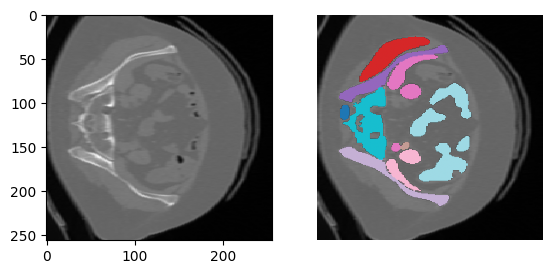

In [7]:
# Let's display some data
# Here is a function to display side by side a slide and a segmented mask
def plot_slice_seg(slice_image, seg):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(slice_image, cmap="gray")
    axes[1].imshow(slice_image, cmap="gray")
    seg_masked = np.ma.masked_where(seg.reshape((256,256)) == 0, (seg.reshape((256,256))))
    axes[1].imshow(seg_masked, cmap="tab20")
    plt.axis("off")

# Let's try it on a slide and ites segmentation mask
# Note: we have to reshape the rows of the dataframe into a 256*256 matrix
plot_slice_seg(data_train[0], labels_train.iloc[0].values.reshape((256,256)))

# Let's compute a baseline

In [8]:
# Let's take a very basic watershed baseline
def compute_baseline_one_sample(data_slice):
    edges = sobel(data_slice)
    denoised = rank.median(data_slice, disk(2))
    markers = rank.gradient(denoised, disk(5)) < 20
    markers = ndi.label(markers)[0]
    label_predicted = watershed(edges, markers=markers, compactness=0.0001)
    return label_predicted

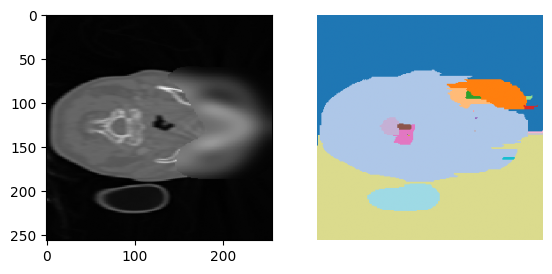

In [9]:
# Let's display the results
# Not too bad!
plot_slice_seg(data_train[2], compute_baseline_one_sample(data_train[2]))

## Let's measure its performances

In [10]:
# Compute the baseline on a whole dataset
def compute_baseline(dataset: np.array):
    labels_predicted_list = []
    for data_index in tqdm(range(len(dataset))):
        data_slice = dataset[data_index]
        label_predicted = compute_baseline_one_sample(data_slice)
        labels_predicted_list.append(label_predicted)
    return pd.DataFrame(np.stack(labels_predicted_list, axis=0).reshape((len(labels_predicted_list), -1)))

In [11]:
# Compute baseline on a few train data
labels_val_predicted_baseline = compute_baseline(data_val)

100%|██████████| 100/100 [00:05<00:00, 18.46it/s]


In [12]:
NUM_CLASSES = 54 # 55 classes in total, but the first one is the background


def dice_image(prediction, ground_truth):
    intersection = np.sum(prediction * ground_truth)
    if np.sum(prediction) == 0 and np.sum(ground_truth) == 0:
        return np.nan
    return 2 * intersection / (np.sum(prediction) + np.sum(ground_truth))


def dice_multiclass(prediction, ground_truth):
    dices = []
    for i in range(1, NUM_CLASSES + 1): # skip background
        dices.append(dice_image(prediction == i, ground_truth == i))
    return np.array(dices)

def dice_pandas(y_true_df: pd.DataFrame, y_pred_df: pd.DataFrame) -> float:
    """Compute the dice score for each sample in the dataset and then average it"""
    y_pred_df = y_pred_df.T
    y_true_df = y_true_df.T
    individual_dice = []
    for row_index in range(y_true_df.values.shape[0]):
        dices = dice_multiclass(y_true_df.values[row_index].ravel(), y_pred_df.values[row_index].ravel())
        individual_dice.append(dices)

    final = np.stack(individual_dice)
    # First, average over images for each class
    # Then, average over classes
    cls_dices = np.nanmean(final, axis=0)
    return float(np.nanmean(cls_dices))


In [13]:
# # Compute the metric on the validation set
# dice_pandas(labels_val, labels_val_predicted_baseline)
# # We get => (0.0011196021617737601); Not so bad, but room for improvements!
# # Let's see if you can do better!

## GET FEATURES

In [14]:
from transformers import AutoModel
from PIL import Image
import requests
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Custom dataset class for multiple grayscale CT scans, this is what we put our data in
class CTDataset(Dataset):
    def __init__(self, images):
        """
        images: A list or NumPy array of shape (N, 256, 256) containing grayscale CT scans.
        """
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]  # Get (256, 256) image
        #return img
        return preprocess_image(img)  # Convert to 3-channel 224x224 tensor
# # Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define preprocessing transforms
transform = T.Compose([
    T.Resize(224),  # Resize to DINOv2 expected input size
    T.ToTensor(),  # Convert to tensor
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25])  # Normalize
])
# transform = T.Compose([
#     T.Resize(224),
#     T.CenterCrop(224),

#     T.ToTensor(),
#     T.Normalize(mean=[0.5], std=[0.5]),
# ])

def preprocess_image(image_array):
    """
    Convert grayscale (256x256) CT scan to a format usable by DINOv2.
    - image_array: NumPy array of shape (256, 256), values in range [0,1].
    - Returns: Tensor of shape (3, 224, 224) ready for DINOv2.
    """
    img = np.stack([image_array] * 3, axis=-1)  # Convert grayscale (H,W) → RGB (H,W,3)
    img = Image.fromarray((img * 255).astype(np.uint8))  # Convert to PIL image
    img = transform(img)  # Apply resizing and normalization
    return img

In [16]:
#THE CELL WHERE YOU CAN CHANGE STUFF

#LOAD MODEL HERE
#in order from smallest to largest, dinov2_vits14 is the smallest model
# model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
# model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
# model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
# model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').to(device)
# LOAD DATASET HERE

#if test data, define the test data, and then put it inside CTDataset
Dataset_train_1 = CTDataset(data_train_1)
DataLoader_train_1 = DataLoader(Dataset_train_1, batch_size=8, shuffle=False)

Dataset_train_2 = CTDataset(data_train_2)
DataLoader_train_2 = DataLoader(Dataset_train_2, batch_size=8, shuffle=False)

Dataset_test = CTDataset(data_test)
DataLoader_test = DataLoader(Dataset_test, batch_size=8, shuffle=False)

Dataset_val = CTDataset(data_val)
DataLoader_val = DataLoader(Dataset_val, batch_size=8, shuffle=False)

# Extract features for all images
# train_patch_features_list = []
# train_cls_features_list = []
# with torch.no_grad():
#     for batch in tqdm(train_dataloader):
#         batch = batch.to(device)
#         features_dict = model.forward_features(batch)
#         #print(features_dict)
#         patch_features = features_dict["x_norm_patchtokens"]  # Patch features
#         cls_features = features_dict["x_norm_clstoken"]  # Patch features
#         train_patch_features_list.append(patch_features)
#         train_cls_features_list.append(cls_features)
#         #train_features_list.append(features.cpu().numpy())

# valid_patch_features_list = []
# valid_cls_features_list = []
# with torch.no_grad():
#     for batch in tqdm(valid_dataloader):
#         batch = batch.to(device)
#         features_dict = model.forward_features(batch)
#         patch_features = features_dict["x_norm_patchtokens"]  # Patch features
#         cls_features = features_dict["x_norm_clstoken"]  # Patch features
#         valid_patch_features_list.append(patch_features)
#         valid_cls_features_list.append(cls_features)

#GET FEATURES
data_train_1_features = []
with torch.no_grad():
    for batch in tqdm(DataLoader_train_1):
        batch = batch.to(device)
        features_dict = model.forward_features(batch)
        patch_features = features_dict["x_norm_patchtokens"]  # Patch features
        data_train_1_features.append(patch_features)

data_train_2_features = []
with torch.no_grad():
    for batch in tqdm(DataLoader_train_2):
        batch = batch.to(device)
        features_dict = model.forward_features(batch)
        patch_features = features_dict["x_norm_patchtokens"]  # Patch features
        data_train_2_features.append(patch_features)

data_val_features = []
with torch.no_grad():
    for batch in tqdm(DataLoader_val):
        batch = batch.to(device)
        features_dict = model.forward_features(batch)
        patch_features = features_dict["x_norm_patchtokens"]  # Patch features
        data_val_features.append(patch_features)

data_test_features = []
with torch.no_grad():
    for batch in tqdm(DataLoader_test):
        batch = batch.to(device)
        features_dict = model.forward_features(batch)
        patch_features = features_dict["x_norm_patchtokens"]  # Patch features
        data_test_features.append(patch_features)




#**ALL FEATURES HERE**
#features = torch.cat(all_patch_features_list, dim=0)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth
100%|██████████| 330M/330M [00:01<00:00, 198MB/s]
100%|██████████| 63/63 [00:07<00:00,  8.38it/s]


torch.Size([8, 256, 768])


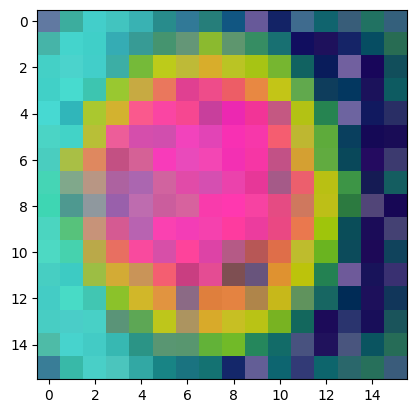

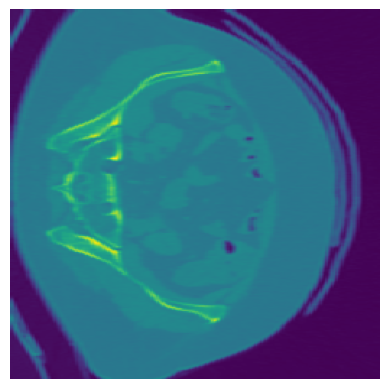

In [17]:
##EVerything below is related to Kmeans, trying to see the effectiveness of the features

import torchvision.transforms as transforms
import torchvision.transforms.functional as F

#PCA visualization, to see if features are good
print(data_train_2_features[0].shape)
b_patch_features = data_train_2_features[0][1]
pca = PCA(n_components=3)
pca_features = pca.fit_transform(b_patch_features.squeeze(0).cpu().numpy())

# Normalize PCA features for visualization
pca_features = (pca_features - pca_features.min()) / (pca_features.max() - pca_features.min())
pca_features = (pca_features * 255).astype(np.uint8)

# Visualize the extracted features as an image
plt.imshow(pca_features.reshape(16, 16, 3))
plt.show()
plt.axis("off")
plt.savefig('meta_dog_features.png')
plt.imshow(data_train[0])

## PUT EVERYTHING IN DATALOADER

In [18]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [19]:
print(f"X_train shape: {data_train.shape}")
print(f"Y_train shape: {labels_train.shape}")

X_train shape: (2000, 256, 256)
Y_train shape: (2000, 65536)


In [20]:
data_train_1_tensor_features = torch.cat(data_train_1_features, dim=0).cpu()
data_train_2_tensor_features = torch.cat(data_train_2_features, dim=0).cpu()
data_test_tensor_features = torch.cat(data_test_features, dim=0).cpu()
data_val_tensor_features = torch.cat(data_val_features, dim=0).cpu()

torch.cuda.empty_cache() #Clean cuda memory (the model take a lot of place)

# Vérifier les dimensions
print("Train 1 features shape:", data_train_1_tensor_features.shape)
print("Train 2 features shape:", data_train_2_tensor_features.shape)
print("Test features shape:", data_test_tensor_features.shape)
print("Validation features shape:", data_val_tensor_features.shape)

Train 1 features shape: torch.Size([350, 256, 768])
Train 2 features shape: torch.Size([350, 256, 768])
Test features shape: torch.Size([500, 256, 768])
Validation features shape: torch.Size([100, 256, 768])


In [21]:
#patch_features = torch.load("all_patch_features.pth")

#features = torch.cat(patch_features, dim=0)

#print("Features shape:", features.shape)

In [22]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np


import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

class MedicalSegDataset(Dataset):
    def __init__(self, images, labels=None, patch_features_tensor=None, is_test=False):
        # Convertir en numpy si c'est un DataFrame Pandas
        if isinstance(images, pd.DataFrame):
            images = images.to_numpy()
        if isinstance(labels, pd.DataFrame) and labels is not None:
            labels = labels.to_numpy()

        self.images = images
        self.labels = labels
        self.patch_features_tensor = patch_features_tensor  # Tenseur de taille (2000, 256, 384)
        self.is_test = is_test  # Indicateur pour savoir si on est en phase de test

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Charger l'image
        image = torch.tensor(self.images[idx], dtype=torch.float32).unsqueeze(0)  # (1, 256, 256)

        # Charger les patch_features
        patch_feature = self.patch_features_tensor[idx]  # (256, 384)
        patch_feature = patch_feature.reshape(16, 16, 768).permute(2, 0, 1)  # (384, 16, 16)

        if self.is_test:
            # En phase de test, on ne retourne pas les labels
            return image, patch_feature
        else:
            # En phase d'entraînement, on retourne les labels
            label = torch.tensor(self.labels[idx], dtype=torch.long).view(256, 256)  # (256, 256)
            return image, label, patch_feature


test_dataset = MedicalSegDataset(data_test, patch_features_tensor=data_test_tensor_features, is_test=True)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

# Inspection du test_loader
for batch_idx, batch_data in enumerate(test_loader):
    image, feature = batch_data

    print(f"Batch {batch_idx + 1}:")
    print(f"  Image shape: {image.shape}, dtype: {image.dtype}, device: {image.device}")
    print(f"  Feature shape: {feature.shape}, dtype: {feature.dtype}, device: {feature.device}")

    if batch_idx >= 2:
        break

val_dataset = MedicalSegDataset(data_val, label_val, data_val_tensor_features)  # Utiliser 100 images pour la validation

val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


# 📌 Création des datasets
train_dataset_1 = MedicalSegDataset(data_train_1, label_train_1, data_train_1_tensor_features)  # Utiliser 350 images pour l'entraînement
train_dataset_2 = MedicalSegDataset(data_train_2,label_train_2, data_train_2_tensor_features)  # Utiliser 350 images pour le 2eme entrainement

train_loader_1 = DataLoader(train_dataset_1, batch_size=8, shuffle=True)
train_loader_2 = DataLoader(train_dataset_2, batch_size=8, shuffle=False)



# Inspect train_loader
for batch_idx, batch_data in enumerate(train_loader_1):
    image, label, feature = batch_data

    print(f"Batch {batch_idx + 1}:")
    print(f"  Image shape: {image.shape}, dtype: {image.dtype}, device: {image.device}")
    print(f"  Label shape: {label.shape}, dtype: {label.dtype}, device: {label.device}")
    print(f"  Feature shape: {feature.shape}, dtype: {feature.dtype}, device: {feature.device}")

    if batch_idx >= 2:
        break

# Inspect val_loader
for batch_idx, batch_data in enumerate(train_loader_2):
    image, label, feature = batch_data

    print(f"Batch {batch_idx + 1}:")
    print(f"  Image shape: {image.shape}, dtype: {image.dtype}, device: {image.device}")
    print(f"  Label shape: {label.shape}, dtype: {label.dtype}, device: {label.device}")
    print(f"  Feature shape: {feature.shape}, dtype: {feature.dtype}, device: {feature.device}")

    if batch_idx >= 2:
        break

Batch 1:
  Image shape: torch.Size([8, 1, 256, 256]), dtype: torch.float32, device: cpu
  Feature shape: torch.Size([8, 768, 16, 16]), dtype: torch.float32, device: cpu
Batch 2:
  Image shape: torch.Size([8, 1, 256, 256]), dtype: torch.float32, device: cpu
  Feature shape: torch.Size([8, 768, 16, 16]), dtype: torch.float32, device: cpu
Batch 3:
  Image shape: torch.Size([8, 1, 256, 256]), dtype: torch.float32, device: cpu
  Feature shape: torch.Size([8, 768, 16, 16]), dtype: torch.float32, device: cpu
Batch 1:
  Image shape: torch.Size([8, 1, 256, 256]), dtype: torch.float32, device: cpu
  Label shape: torch.Size([8, 256, 256]), dtype: torch.int64, device: cpu
  Feature shape: torch.Size([8, 768, 16, 16]), dtype: torch.float32, device: cpu
Batch 2:
  Image shape: torch.Size([8, 1, 256, 256]), dtype: torch.float32, device: cpu
  Label shape: torch.Size([8, 256, 256]), dtype: torch.int64, device: cpu
  Feature shape: torch.Size([8, 768, 16, 16]), dtype: torch.float32, device: cpu
Batch 3

In [23]:
class DiceLoss(nn.Module):
    def __init__(self, n_classes):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes

    def _one_hot_encoder(self, input_tensor):
        tensor_list = []
        for i in range(self.n_classes):
            temp_prob = input_tensor == i  # * torch.ones_like(input_tensor)
            tensor_list.append(temp_prob.unsqueeze(1))
        output_tensor = torch.cat(tensor_list, dim=1)
        return output_tensor.float()

    def _dice_loss(self, score, target):
        target = target.float()
        smooth = 1e-5
        intersect = torch.sum(score * target)
        y_sum = torch.sum(target * target)
        z_sum = torch.sum(score * score)
        loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
        loss = 1 - loss
        return loss

    def forward(self, inputs, target, weight=None, softmax=False):
        if softmax:
            inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot_encoder(target)
        if weight is None:
            weight = [1] * self.n_classes
        assert inputs.size() == target.size(), 'predict {} & target {} shape do not match'.format(inputs.size(), target.size())
        class_wise_dice = []
        loss = 0.0
        for i in range(0, self.n_classes):
            dice = self._dice_loss(inputs[:, i], target[:, i])
            class_wise_dice.append(1.0 - dice.item())
            loss += dice * weight[i]
        return loss / self.n_classes


## MODEL WITH ONLY IMAGES

In [24]:
# from monai.networks.nets import SwinUNETR

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Change img_size to match the actual image size (256, 256)
# model_swin_both = SwinUNETR(
#     img_size=(256, 256),  # Match the actual input image size
#     in_channels=1,  # Images CT-scan en niveaux de gris
#     out_channels=NUM_CLASSES+1,  # Nombre de classes
#     use_checkpoint=True,  # Gradient checkpointing pour économiser la mémoire
#     spatial_dims=2,  # Important pour utiliser la version 2D
# ).to(device)

# torch.backends.cudnn.benchmark = True
# ce_loss = nn.CrossEntropyLoss()
# dice_loss = DiceLoss(NUM_CLASSES+1)
# optimizer = optim.AdamW(model_swin_both.parameters(), lr=0.0005, weight_decay=1e-5)
# scaler = torch.cuda.amp.GradScaler()

# # Boucle d'entraînement simple
# num_epochs = 80  # Ajuste selon tes besoins
# losses = []
# val_losses = []
# counter = 0  # Compteur d'époques sans amélioration
# patience = 10  # Nombre d'époques sans amélioration avant d'arrêter
# best_val_loss = float('inf')

# for epoch in tqdm(range(num_epochs)):
#     model_swin_both.train()
#     running_loss = 0.0

#     for images, labels, features in train_loader_1:
#         images, labels = images.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model_swin_both(images)

#         loss_ce = ce_loss(outputs, labels)
#         loss_dice = dice_loss(outputs, labels, softmax=True)
#         loss = 0.4 * loss_ce + 0.6 * loss_dice
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     losses.append(running_loss / len(train_loader_1))
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader_1):.4f}")

#     # ---- ÉVALUATION ----
#     model_swin_both.eval()  # Met le modèle en mode évaluation

#     val_loss = 0.0  # Variable pour accumuler la perte de validation
#     with torch.no_grad():
#         for images, labels, features in train_loader_2:
#             images, labels = images.to(device), labels.to(device)

#             # Passer les images dans le modèle
#             outputs = model_swin_both(images)

#             # Calcul de la CrossEntropyLoss
#             loss_dice = dice_loss(outputs, labels, softmax=True)
#             val_loss +=  loss_dice

#     # Moyenne de la perte de validation
#     val_loss = val_loss / len(train_loader_2)
#     print(f"Validation Loss: {val_loss:.4f}")

#     # Optionnel : afficher la progression de la perte de validation
#     val_losses.append(val_loss)

#     # Sauvegarder le modèle si la perte de validation est la meilleure vue jusqu'à présent
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         torch.save(model_swin_both.state_dict(), "best_model_vanilla.pth")
#         counter = 0
#     else:
#         counter += 1
#     if counter == patience:
#         print(f"Arrêt prématuré à l'époque {epoch+1}")
#         break



In [25]:
# val_losses_cpu = [loss.cpu().numpy() for loss in val_losses]

# # ---- GRAPHIQUES ----
# plt.figure(figsize=(10,5))
# plt.subplot(1,2,1)
# plt.plot(losses, label="Training Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Loss during Training")
# plt.legend()

# plt.subplot(1,2,2)
# plt.plot(val_losses_cpu, label="Validation Loss", color="orange")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Validation Loss")
# plt.legend()

# plt.show()

In [26]:
# model_swin_both.eval()  # Met le modèle en mode évaluation

# all_preds = []
# all_labels = []
# with torch.no_grad():
#     for images, labels, features in (train_loader_2):
#         images, labels, features = images.to(device), labels.to(device), features.to(device)

#         # Passer les images dans le modèle
#         outputs = model_swin_both(images)

#         # Obtenir les prédictions en prenant l'argmax sur la dimension des classes
#         preds = torch.argmax(outputs, dim=1).cpu().numpy()  # (batch_size, H, W)
#         labels = labels.cpu().numpy()  # (batch_size, H, W)

#         # Stocker les résultats pour le calcul du Dice
#         all_preds.append(preds)
#         all_labels.append(labels)

# # Convertir en NumPy
# all_preds = np.concatenate(all_preds, axis=0)  # (num_images, H, W)
# all_labels = np.concatenate(all_labels, axis=0)  # (num_images, H, W)

# # Transformer en DataFrame pour tes fonctions
# all_preds_df = pd.DataFrame(all_preds.reshape(all_preds.shape[0], -1))  # (num_images, H*W)
# all_labels_df = pd.DataFrame(all_labels.reshape(all_labels.shape[0], -1))  # (num_images, H*W)

# # Calcul du Dice Score
# dice_score_both = dice_pandas(all_labels_df, all_preds_df)

# print(f"Validation Dice Score: {dice_score_both:.4f}")

In [27]:
# torch.save(model_swin_both.state_dict(), 'best_model_vanilla.pth')
# torch.cuda.empty_cache()

In [28]:
# from monai.networks.nets import SwinUNETR

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Recréer le modèle avec la même architecture
# best_model = SwinUNETR(
#     img_size=(256, 256),
#     in_channels=1,
#     out_channels=NUM_CLASSES+1,
#     use_checkpoint=True,
#     spatial_dims=2,
# ).to(device)

# # Charger les poids
# best_model.load_state_dict(torch.load("best_model_vanilla.pth"))
# best_model.eval()


In [29]:
# best_model.eval()  # Met le modèle en mode évaluation

# all_preds = []
# all_labels = []
# with torch.no_grad():
#     for images, labels, features in train_loader_2:
#         images, labels, features = images.to(device), labels.to(device), features.to(device)

#         # Passer les images dans le modèle
#         outputs = best_model(images)

#         # Obtenir les prédictions en prenant l'argmax sur la dimension des classes
#         preds = torch.argmax(outputs, dim=1).cpu().numpy()  # (batch_size, H, W)
#         labels = labels.cpu().numpy()  # (batch_size, H, W)

#         # Stocker les résultats pour le calcul du Dice
#         all_preds.append(preds)
#         all_labels.append(labels)

# # Convertir en NumPy
# all_preds = np.concatenate(all_preds, axis=0)  # (num_images, H, W)
# all_labels = np.concatenate(all_labels, axis=0)  # (num_images, H, W)

# # Transformer en DataFrame pour tes fonctions
# all_preds_df = pd.DataFrame(all_preds.reshape(all_preds.shape[0], -1))  # (num_images, H*W)
# all_labels_df = pd.DataFrame(all_labels.reshape(all_labels.shape[0], -1))  # (num_images, H*W)

# # Calcul du Dice Score
# dice_score = dice_pandas(all_labels_df, all_preds_df)

# print(f"Validation Dice Score: {dice_score:.4f}")

In [30]:
# import pandas as pd
# import numpy as np
# import torch
# from tqdm import tqdm

# # Function to get predictions
# def get_predictions(model, dataloader, device):
#     model.eval()
#     predictions = []

#     with torch.no_grad():
#         for images, features in tqdm(dataloader, desc="Generating predictions"):
#             images = images.to(device)
#             outputs = model(images)  # Output shape: (batch_size, num_classes, 256, 256)
#             preds = torch.argmax(outputs, dim=1)  # Get the most probable class
#             predictions.append(preds.cpu().numpy())  # Convert to numpy

#     return np.concatenate(predictions, axis=0)  # Final shape: (N, 256, 256)

# # Get predictions on the test set
# predictions_test = get_predictions(best_model, test_loader, device)  # Shape: (N, 256, 256)
# print("Predictions shape:", predictions_test.shape)

# # Reshape predictions to have one row per pixel (instead of image)
# n_images = predictions_test.shape[0]  # Number of images
# n_pixels = 256 * 256  # Total number of pixels (256 * 256)

# # Correct reshaping: each row represents a pixel, and each column an image
# predictions_flat = predictions_test.transpose(1, 2, 0).reshape(n_pixels, n_images)  # Shape: (256*256, N)

# # Create DataFrame
# columns = [f"{i}.png" for i in range(n_images)]
# df = pd.DataFrame(predictions_flat, columns=columns)  # Each column is an image

# # Add a 'Pixel' column for each row representing pixel positions
# df.insert(0, "Pixel", [f"Pixel {i}" for i in range(n_pixels)])

# # Save to CSV with proper formatting
# df.to_csv("predictions.csv", index=False, encoding='utf-8')
# print("CSV file saved successfully!")


In [31]:
# # Fonction pour afficher une image, sa prédiction et son label réel
# def plot_slice_seg(image, pred, label, idx=0):
#     """
#     Affiche une image en niveaux de gris avec la segmentation prédite et la segmentation réelle.

#     image : image originale (3D ou 2D)
#     pred  : prédiction du modèle (2D, classes)
#     label : ground truth (2D, classes)
#     idx   : index de l'exemple à afficher
#     """
#     fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#     # Affichage de l'image originale
#     axes[0].imshow(image[idx % image.shape[0]].squeeze(), cmap="gray") # Use modulo operator to ensure idx is within bounds
#     axes[0].set_title("Image originale")

#     # Affichage de la prédiction
#     pred_masked = np.ma.masked_where(pred[idx % pred.shape[0]] == 0, pred[idx % pred.shape[0]])  # Masquer le fond (classe 0) # Use modulo operator to ensure idx is within bounds
#     axes[1].imshow(image[idx % image.shape[0]].squeeze(), cmap="gray") # Use modulo operator to ensure idx is within bounds
#     axes[1].imshow(pred_masked, cmap="tab20", alpha=0.6)
#     axes[1].set_title("Segmentation prédite")

#     # Affichage du label réel
#     label_masked = np.ma.masked_where(label[idx % label.shape[0]] == 0, label[idx % label.shape[0]]) # Use modulo operator to ensure idx is within bounds
#     axes[2].imshow(image[idx % image.shape[0]].squeeze(), cmap="gray") # Use modulo operator to ensure idx is within bounds
#     axes[2].imshow(label_masked, cmap="tab20", alpha=0.6)
#     axes[2].set_title("Segmentation réelle")

#     # Ajout des numéros de classe
#     for i in range(1, NUM_CLASSES + 1): # On ignore le fond (classe 0)
#         # Trouver les coordonnées des pixels appartenant à la classe i
#         pred_coords = np.argwhere(pred[idx % pred.shape[0]] == i)
#         label_coords = np.argwhere(label[idx % label.shape[0]] == i)

#         # Afficher le numéro de classe au centre de la zone (approximativement)
#         if len(pred_coords) > 0:
#             center_pred = pred_coords.mean(axis=0).astype(int)
#             axes[1].text(center_pred[1], center_pred[0], str(i), color='white', ha='center', va='center')
#         if len(label_coords) > 0:
#             center_label = label_coords.mean(axis=0).astype(int)
#             axes[2].text(center_label[1], center_label[0], str(i), color='white', ha='center', va='center')


#     for ax in axes:
#         ax.axis("off")

#     plt.show()

# # Sélectionner un index aléatoire pour visualiser un exemple de validation
# idx = np.random.randint(len(train_dataset_2)-1)  # Si val_dataset est ta liste d'images de validation

# # Get a batch of images, labels, and features from the validation loader at the random index
# image, label, feature = train_dataset_2[idx]
# image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
# feature = feature.unsqueeze(0).to(device)  # Add batch dimension and move to device

# with torch.no_grad():
#     output = best_model(image)  # Get the model's prediction
#     pred = torch.argmax(output, dim=1).cpu().numpy()  # Get the predicted class labels

# plot_slice_seg(
#     image.cpu().numpy(),  # Images d'entrée (tensor → NumPy)
#     pred,  # Prédictions (déjà en NumPy)
#     label.unsqueeze(0).numpy(),  # Labels réels (déjà en NumPy) # Add batch dimension
#     idx  # Index to use for plotting (always 0 since we're using a single image)
# )

In [32]:
torch.cuda.empty_cache()

## MODEL WITH IMAGES AND FEATURES

In [33]:
!pip install monai
import torch
import monai
from monai.networks.nets import SwinUNETR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Change img_size to match the actual image size (256, 256)
model = SwinUNETR(
    img_size=(256, 256),  # Match the actual input image size
    in_channels=1,  # Images CT-scan en niveaux de gris
    out_channels=NUM_CLASSES+1,  # Nombre de classes
    use_checkpoint=True,  # Gradient checkpointing pour économiser la mémoire
    spatial_dims=2,  # Important pour utiliser la version 2D
).to(device)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


In [34]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from monai.networks.nets import SwinUNETR  # Assurez-vous d'importer le bon module

# class SwinUNETRWithFeatures(nn.Module):
#     def __init__(self,
#                  img_size=(256, 256),
#                  in_channels=1,
#                  out_channels=NUM_CLASSES+1,
#                  pretrained_model=None):
#         super(SwinUNETRWithFeatures, self).__init__()

#         # Backbone SwinUNETR pré-entraîné
#         self.swin_unetr = SwinUNETR(
#             img_size=img_size,
#             in_channels=in_channels,
#             out_channels=out_channels,
#             use_checkpoint=True,
#             spatial_dims=2
#         )

#         if pretrained_model is not None:
#             # Charger les poids pré-entraînés dans le backbone
#             self.swin_unetr.load_state_dict(pretrained_model, strict=False)

#         # Branch pour traiter les patch features
#         # Ici on suppose que les patch features sont de taille (384, 16, 16)
#         # On peut par exemple les transformer pour obtenir une carte de dimension (C, H, W)
#         # afin de les fusionner avec le decoder (ou directement dans le head)
#         self.features_conv = nn.Sequential(
#             nn.Conv2d(768, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True)
#         )

#         # Module de fusion (par exemple, concaténer les deux cartes et les traiter)
#         # On suppose que la sortie du SwinUNETR est de taille (B, out_channels, H, W)
#         # et que l'on veut fusionner la branche features après une redimension
#         self.fusion_conv = nn.Sequential(
#             nn.Conv2d(out_channels + 64, out_channels, kernel_size=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, image, patch_feature):
#         # Passage dans le modèle de base
#         seg_out = self.swin_unetr(image)  # sortie de taille (B, out_channels, H, W)

#         # Traitement des patch features
#         # patch_feature: (B, 384, 16, 16)
#         features = self.features_conv(patch_feature)  # -> (B, 64, 16, 16)

#         # Si nécessaire, redimensionner la carte de features pour qu'elle ait la même taille que seg_out
#         # On utilise ici une interpolation bilinéaire
#         features_upsampled = F.interpolate(features, size=seg_out.shape[2:], mode='bilinear', align_corners=False)

#         # Fusionner les deux features (concaténation sur la dimension des canaux)
#         fused = torch.cat([seg_out, features_upsampled], dim=1)
#         out = self.fusion_conv(fused)

#         return out
import torch
import torch.nn as nn
import torch.nn.functional as F
from monai.networks.nets import SwinUNETR

class SwinUNETRWithFeatures(nn.Module):
    def __init__(self, img_size=(224, 224), in_channels=1, out_channels=55):
        """
        Uses DINOv2 as the encoder and SwinUNETR as the decoder.
        - img_size: internal processing size (set to 224×224).
        - in_channels: number of input channels (will be converted to 3 if 1).
        - out_channels: segmentation output channels (always NUM_CLASSES+1, here 55 since NUM_CLASSES=54).
        """
        super().__init__()
        self.img_size = img_size
        self.in_channels = in_channels
        self.out_channels = out_channels  # Should be 55 (54+1)

        # Load DINOv2 (dinov2_vits14) from torch.hub.
        self.dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
        # Remove the classification head to use internal patch tokens.
        self.dino.head = nn.Identity()

        # Create the SwinUNETR decoder. It expects in_channels=768.
        self.decoder = SwinUNETR(
            img_size=img_size,           # 224×224
            in_channels=768,             # Must be 768 for the decoder.
            out_channels=self.out_channels,
            use_checkpoint=True,
            spatial_dims=2
        )

        # Projection layer: map DINOv2 patch tokens from 384 channels to 768 channels.
        self.proj = nn.Conv2d(self.dino.patch_embed.proj.out_channels, 768, kernel_size=1)

    def interpolate_pos_embed(self, pos_embed, new_grid_size, num_extra_tokens=1):
        """
        Interpolates positional embeddings to a new grid size.
        pos_embed: Tensor of shape (1, L, D), where L = num_extra_tokens + old_num_patches.
        new_grid_size: Tuple (new_H, new_W) for the grid.
        Returns:
            Tensor of shape (1, num_extra_tokens + new_H*new_W, D).
        """
        extra_tokens = pos_embed[:, :num_extra_tokens]  # (1, num_extra_tokens, D)
        grid_tokens = pos_embed[:, num_extra_tokens:]     # (1, old_num_patches, D)
        old_grid_size = int(grid_tokens.shape[1] ** 0.5)
        D = grid_tokens.shape[-1]
        # Reshape to (1, D, old_H, old_W)
        grid_tokens = grid_tokens.reshape(1, old_grid_size, old_grid_size, D).permute(0, 3, 1, 2)
        # Interpolate using bicubic interpolation.
        grid_tokens = F.interpolate(grid_tokens, size=new_grid_size, mode='bicubic', align_corners=False)
        # Reshape back to (1, new_H*new_W, D)
        grid_tokens = grid_tokens.permute(0, 2, 3, 1).reshape(1, new_grid_size[0] * new_grid_size[1], D)
        return torch.cat([extra_tokens, grid_tokens], dim=1)

    def get_patch_tokens(self, x):
        """
        Extracts patch tokens from DINOv2's internal components.
        Input:
            x: Tensor of shape (B, 3, H, W) — expected to be resized to img_size (224×224).
        Returns:
            Tensor of shape (B, 1+N, 384), where N is the number of patch tokens.
        """
        # Get patch tokens via patch embedding.
        x = self.dino.patch_embed(x)  # (B, N, 384)
        B, N, D = x.shape
        # Prepend the CLS token.
        cls_tokens = self.dino.cls_token.expand(B, -1, -1)  # (B, 1, 384)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, 1+N, 384)

        # Interpolate positional embeddings if needed.
        total_tokens = x.size(1)  # (1+N)
        if self.dino.pos_embed.size(1) != total_tokens:
            new_grid_side = int((total_tokens - 1) ** 0.5)
            new_pos_embed = self.interpolate_pos_embed(self.dino.pos_embed, (new_grid_side, new_grid_side), num_extra_tokens=1)
        else:
            new_pos_embed = self.dino.pos_embed
        x = x + new_pos_embed

        # Apply positional dropout if available.
        if hasattr(self.dino, "pos_drop"):
            x = self.dino.pos_drop(x)

        # Process tokens through transformer blocks.
        for blk in self.dino.blocks:
            x = blk(x)
        return x  # (B, 1+N, 384)

    def forward(self, image):
        """
        Forward pass:
          - Converts grayscale input (if necessary) to 3 channels.
          - Resizes image to img_size (224×224).
          - Extracts patch tokens via DINOv2.
          - Removes the CLS token and reshapes tokens into a spatial feature map.
          - Applies a projection from 384 to 768 channels.
          - Upsamples the feature map to img_size and feeds it into the decoder.
          - Upsamples the decoder output to 256×256 to match label sizes.
        """
        # If input is grayscale, replicate channels to make 3 channels.
        if image.shape[1] == 1:
            image = image.repeat(1, 3, 1, 1)
        # Resize image to img_size (224×224).
        image = F.interpolate(image, size=self.img_size, mode='bilinear', align_corners=False)

        # Extract patch tokens (B, 1+N, 384).
        tokens = self.get_patch_tokens(image)
        # Remove the CLS token -> (B, N, 384).
        tokens = tokens[:, 1:, :]
        B, N, D = tokens.shape

        # Assume tokens form a square grid.
        grid_side = int(N ** 0.5)
        if grid_side * grid_side != N:
            raise ValueError(f"Number of tokens {N} does not form a square grid.")
        # Reshape tokens into a spatial feature map: (B, 384, grid_side, grid_side).
        feature_map = tokens.reshape(B, grid_side, grid_side, D).permute(0, 3, 1, 2)

        # PROJECT the feature map from 384 channels to 768 channels.
        proj_feature_map = self.proj(feature_map)
        # Upsample the feature map to img_size (224×224).
        proj_feature_map = F.interpolate(proj_feature_map, size=self.img_size, mode='bilinear', align_corners=False)

        # Pass the projected features to the SwinUNETR decoder.
        seg_out = self.decoder(proj_feature_map)
        # Finally, upsample the segmentation output to 256×256 to match label sizes.
        seg_out = F.interpolate(seg_out, size=(256, 256), mode='bilinear', align_corners=False)
        return seg_out



    # def forward(self, image):
    #     # Extract features using DINOv2.
    #     # It should produce a feature map of shape (B, 768, H', W'),
    #     # where H' and W' might be smaller than the original image dimensions.
    #     image = self.transform(image)
    #     dino_features = self.dino(image)

    #     # Upsample the DINOv2 features to match the expected input size for the decoder.
    #     # Here we assume the decoder expects (B, 768, 256, 256).
    #     dino_features_upsampled = F.interpolate(dino_features, size=(256, 256), mode='bilinear', align_corners=False)

    #     # Pass the upsampled features to the SwinUNETR decoder to produce the segmentation output.
    #     seg_out = self.decoder(dino_features_upsampled)
    #     return seg_out


In [35]:

# Créez une instance de votre nouveau modèle en passant les poids pré-entraînés
model_with_features = SwinUNETRWithFeatures(
    img_size=(224, 224),
    in_channels=1,
    out_channels=NUM_CLASSES+1,
).to(device)


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:01<00:00, 55.8MB/s]


In [ ]:
from monai.networks.nets import SwinUNETR
import os
torch.cuda.empty_cache()
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.benchmark = True
ce_loss = nn.CrossEntropyLoss()
dice_loss = DiceLoss(NUM_CLASSES+1)
optimizer = optim.AdamW(model_with_features.parameters(), lr=0.0005, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

# Boucle d'entraînement simple
num_epochs = 120  # Ajuste selon tes besoins
losses = []
val_losses = []
counter = 0  # Compteur d'époques sans amélioration
patience = 10  # Nombre d'époques sans amélioration avant d'arrêter
best_val_loss = float('inf')

for epoch in tqdm(range(num_epochs)):
    model_with_features.train()
    running_loss = 0.0

    for images, labels, features in train_loader_1:
        images = images.to(device)
        labels = labels.to(device).long()  # ensure correct type

        # Debug: print label range to ensure they are within [0, 54]
        if labels.min() < 0 or labels.max() >= 55:
            raise ValueError(f"Label values out of range: min={labels.min().item()}, max={labels.max().item()}")

        optimizer.zero_grad()
        outputs = model_with_features(images)
        loss_ce = ce_loss(outputs, labels)
        loss_dice = dice_loss(outputs, labels, softmax=True)
        loss = 0.4 * loss_ce + 0.6 * loss_dice
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    losses.append(running_loss / len(train_loader_1))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader_1):.4f}")

    # ---- ÉVALUATION ----
    model_with_features.eval()  # Met le modèle en mode évaluation

    val_loss = 0.0  # Variable pour accumuler la perte de validation
    with torch.no_grad():
        for images, labels, features in train_loader_2:
            images, labels, features = images.to(device), labels.to(device), features.to(device)

            # Passer les images dans le modèle
            outputs = model_with_features(images)

            # Calcul de la CrossEntropyLoss
            loss_dice = dice_loss(outputs, labels, softmax=True)
            val_loss +=  loss_dice

    # Moyenne de la perte de validation
    val_loss = val_loss / len(train_loader_2)
    print(f"Validation Loss: {val_loss:.4f}")

    # Optionnel : afficher la progression de la perte de validation
    val_losses.append(val_loss)

    # Sauvegarder le modèle si la perte de validation est la meilleure vue jusqu'à présent
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_with_features.state_dict(), "best_model_with_features.pth")
        counter = 0
    else:
        counter += 1
    if counter == patience:
        print(f"Arrêt prématuré à l'époque {epoch+1}")
        break

<ipython-input-36-0fa4152212ee>:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
  0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from monai.networks.nets import SwinUNETR

# # Utility functions for padding and cropping
# def pad_to_multiple(x, multiple):
#     B, C, H, W = x.shape
#     pad_h = (multiple - H % multiple) % multiple
#     pad_w = (multiple - W % multiple) % multiple
#     pad_top = pad_h // 2
#     pad_bottom = pad_h - pad_top
#     pad_left = pad_w // 2
#     pad_right = pad_w - pad_left
#     return F.pad(x, (pad_left, pad_right, pad_top, pad_bottom)), (pad_top, pad_left, H, W)

# def crop_to_original(x, pad_info):
#     pad_top, pad_left, H, W = pad_info
#     return x[..., pad_top:pad_top+H, pad_left:pad_left+W]

# def interpolate_pos_embed(pos_embed, new_grid_size, num_extra_tokens=1):
#     """
#     Interpolates the positional embeddings to a new grid size.
#     pos_embed: (1, L, D) where L = num_extra_tokens + old_num_patches
#     new_grid_size: tuple (new_H, new_W) for the grid (excluding extra tokens)
#     """
#     # Separate the extra tokens (like the CLS token) from the grid tokens.
#     extra_tokens = pos_embed[:, :num_extra_tokens]  # shape: (1, num_extra_tokens, D)
#     grid_tokens = pos_embed[:, num_extra_tokens:]     # shape: (1, old_num_patches, D)
#     old_grid_size = int(grid_tokens.size(1) ** 0.5)
#     D = grid_tokens.size(-1)
#     # Reshape to (1, D, old_H, old_W)
#     grid_tokens = grid_tokens.reshape(1, old_grid_size, old_grid_size, D).permute(0, 3, 1, 2)
#     # Interpolate using bicubic interpolation.
#     grid_tokens = F.interpolate(grid_tokens, size=new_grid_size, mode='bicubic', align_corners=False)
#     # Reshape back to (1, new_H*new_W, D)
#     grid_tokens = grid_tokens.permute(0, 2, 3, 1).reshape(1, new_grid_size[0] * new_grid_size[1], D)
#     # Concatenate the extra tokens back.
#     return torch.cat([extra_tokens, grid_tokens], dim=1)

# class SwinUNETRWithFeatures(nn.Module):
#     def __init__(self,
#                  img_size=(256, 256),
#                  in_channels=1,
#                  out_channels=4,  # e.g., NUM_CLASSES+1; adjust as needed
#                  pretrained_dino=None):
#         super(SwinUNETRWithFeatures, self).__init__()

#         # Load the pretrained DINOv2 model.
#         self.dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
#         # Remove the head so we can extract patch tokens.
#         if hasattr(self.dino, 'head'):
#             self.dino.head = nn.Identity()

#         # Create a SwinUNETR decoder that accepts DINOv2 features.
#         # DINOv2's patch tokens have a feature dimension of 768.
#         self.decoder = SwinUNETR(
#             img_size=img_size,
#             in_channels=768,
#             out_channels=out_channels,
#             use_checkpoint=True,
#             spatial_dims=2
#         )

#     def get_patch_tokens(self, x):
#         """
#         Extract patch tokens from the input using DINOv2 components.
#         Returns a tensor of shape (B, 1+N, 768) where N is the number of patches.
#         """
#         # x: (B, 3, H, W)
#         x = self.dino.patch_embed(x)  # shape: (B, num_patches, 768)
#         B, N, D = x.shape
#         # Expand the CLS token and concatenate.
#         cls_tokens = self.dino.cls_token.expand(B, -1, -1)  # (B, 1, 768)
#         x = torch.cat((cls_tokens, x), dim=1)  # (B, 1+N, 768)

#         # Interpolate the positional embeddings if needed.
#         L = x.size(1)  # expected total tokens = 1 + N
#         # Compute the new grid size from N (exclude the CLS token).
#         grid_side = int((L - 1) ** 0.5)
#         new_pos_embed = interpolate_pos_embed(self.dino.pos_embed, (grid_side, grid_side), num_extra_tokens=1)

#         x = x + new_pos_embed  # broadcast addition
#         x = self.dino.pos_drop(x)

#         # Run the tokens through the transformer blocks.
#         for blk in self.dino.blocks:
#             x = blk(x)
#         return x

#     def forward(self, image):
#         # If the input image is grayscale, replicate to get an RGB image.
#         if image.shape[1] == 1:
#             image = image.repeat(1, 3, 1, 1)

#         # Pad the image so that H and W are multiples of 14 (the patch size).
#         image_padded, pad_info = pad_to_multiple(image, 14)

#         # Extract patch tokens using the helper.
#         tokens = self.get_patch_tokens(image_padded)
#         # Remove the CLS token.
#         tokens = tokens[:, 1:, :]  # now (B, N, 768)

#         # Compute the spatial dimensions from the number of tokens.
#         B, N, C = tokens.shape
#         H_feat = int(N ** 0.5)
#         if H_feat * H_feat != N:
#             raise ValueError(f"Expected a square number of tokens, but got {N}")

#         # Reshape tokens into a spatial feature map: (B, 768, H_feat, H_feat)
#         tokens = tokens.reshape(B, H_feat, H_feat, C).permute(0, 3, 1, 2)

#         # Upsample the DINOv2 features to match the padded image size.
#         padded_size = image_padded.shape[-2:]
#         dino_features_upsampled = F.interpolate(tokens, size=padded_size, mode='bilinear', align_corners=False)

#         # Pass the upsampled features through the SwinUNETR decoder.
#         seg_out_padded = self.decoder(dino_features_upsampled)

#         # Crop the segmentation output back to the original image size.
#         seg_out = crop_to_original(seg_out_padded, pad_info)
#         return seg_out





# # --- Training Setup ---

# # Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Instantiate the model and move it to the device.
# model_with_features = SwinUNETRWithFeatures(img_size=(256,256), in_channels=1, out_channels=NUM_CLASSES+1)
# model_with_features = model_with_features.to(device)

# # Loss functions and optimizer
# ce_loss = nn.CrossEntropyLoss()
# dice_loss = DiceLoss(NUM_CLASSES+1)
# optimizer = optim.AdamW(model_with_features.parameters(), lr=0.0005, weight_decay=1e-5)
# scaler = torch.cuda.amp.GradScaler()

# # Assume train_loader_1 and train_loader_2 are defined and yield (images, labels, _)
# num_epochs = 80  # Adjust as needed
# losses = []
# val_losses = []
# counter = 0  # Count epochs without improvement
# patience = 10  # Early stopping patience
# best_val_loss = float('inf')

# for epoch in tqdm(range(num_epochs)):
#     model_with_features.train()
#     running_loss = 0.0

#     for images, labels, _ in train_loader_1:  # Ignore extra features if provided
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()

#         # Forward pass: use only the image.
#         outputs = model_with_features(images)

#         loss_ce = ce_loss(outputs, labels)
#         loss_dice = dice_loss(outputs, labels, softmax=True)
#         loss = 0.4 * loss_ce + 0.6 * loss_dice
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()

#     avg_train_loss = running_loss / len(train_loader_1)
#     losses.append(avg_train_loss)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")

#     # ---- Evaluation ----
#     model_with_features.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for images, labels, _ in train_loader_2:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model_with_features(images)
#             loss_dice_val = dice_loss(outputs, labels, softmax=True)
#             val_loss += loss_dice_val.item()
#     val_loss /= len(train_loader_2)
#     print(f"Validation Loss: {val_loss:.4f}")
#     val_losses.append(val_loss)

#     # Save best model and implement early stopping.
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         torch.save(model_with_features.state_dict(), "best_model_with_features.pth")
#         counter = 0
#     else:
#         counter += 1
#     if counter == patience:
#         print(f"Early stopping at epoch {epoch+1}")
#         break


In [ ]:
val_losses_cpu = [loss.cpu().numpy() for loss in val_losses]

# ---- GRAPHIQUES ----
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during Training")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_losses_cpu, label="Validation Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.legend()

plt.show()

In [ ]:
model_with_features.eval()  # Met le modèle en mode évaluation

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels, features in train_loader_2:
        images, labels, features = images.to(device), labels.to(device), features.to(device)

        # Passer les images dans le modèle
        outputs = model_with_features(images)

        # Obtenir les prédictions en prenant l'argmax sur la dimension des classes
        preds = torch.argmax(outputs, dim=1).cpu().numpy()  # (batch_size, H, W)
        labels = labels.cpu().numpy()  # (batch_size, H, W)

        # Stocker les résultats pour le calcul du Dice
        all_preds.append(preds)
        all_labels.append(labels)

# Convertir en NumPy
all_preds = np.concatenate(all_preds, axis=0)  # (num_images, H, W)
all_labels = np.concatenate(all_labels, axis=0)  # (num_images, H, W)

# Transformer en DataFrame pour tes fonctions
all_preds_df = pd.DataFrame(all_preds.reshape(all_preds.shape[0], -1))  # (num_images, H*W)
all_labels_df = pd.DataFrame(all_labels.reshape(all_labels.shape[0], -1))  # (num_images, H*W)

# Calcul du Dice Score
dice_score = dice_pandas(all_labels_df, all_preds_df)

print(f"Validation Dice Score: {dice_score:.4f}")

In [ ]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm

# Function to get predictions
def get_predictions(model, dataloader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images, features in tqdm(dataloader, desc="Generating predictions"):
            images, features = images.to(device), features.to(device)
            outputs = model(images)  # Output shape: (batch_size, num_classes, 256, 256)
            preds = torch.argmax(outputs, dim=1)  # Get the most probable class
            predictions.append(preds.cpu().numpy())  # Convert to numpy

    return np.concatenate(predictions, axis=0)  # Final shape: (N, 256, 256)

# Get predictions on the test set
predictions_test = get_predictions(model_with_features, test_loader, device)  # Shape: (N, 256, 256)
print("Predictions shape:", predictions_test.shape)

# Reshape predictions to have one row per pixel (instead of image)
n_images = predictions_test.shape[0]  # Number of images
n_pixels = 256 * 256  # Total number of pixels (256 * 256)

# Correct reshaping: each row represents a pixel, and each column an image
predictions_flat = predictions_test.transpose(1, 2, 0).reshape(n_pixels, n_images)  # Shape: (256*256, N)

# Create DataFrame
columns = [f"{i}.png" for i in range(n_images)]
df = pd.DataFrame(predictions_flat, columns=columns)  # Each column is an image

# Add a 'Pixel' column for each row representing pixel positions
df.insert(0, "Pixel", [f"Pixel {i}" for i in range(n_pixels)])

# Save to CSV with proper formatting
df.to_csv("predictions_with_features.csv", index=False, encoding='utf-8')
print("CSV file saved successfully!")

In [ ]:
# Fonction pour afficher une image, sa prédiction et son label réel
def plot_slice_seg(image, pred, label, idx=0):
    """
    Affiche une image en niveaux de gris avec la segmentation prédite et la segmentation réelle.

    image : image originale (3D ou 2D)
    pred  : prédiction du modèle (2D, classes)
    label : ground truth (2D, classes)
    idx   : index de l'exemple à afficher
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Affichage de l'image originale
    axes[0].imshow(image[idx % image.shape[0]].squeeze(), cmap="gray") # Use modulo operator to ensure idx is within bounds
    axes[0].set_title("Image originale")

    # Affichage de la prédiction
    pred_masked = np.ma.masked_where(pred[idx % pred.shape[0]] == 0, pred[idx % pred.shape[0]])  # Masquer le fond (classe 0) # Use modulo operator to ensure idx is within bounds
    axes[1].imshow(image[idx % image.shape[0]].squeeze(), cmap="gray") # Use modulo operator to ensure idx is within bounds
    axes[1].imshow(pred_masked, cmap="tab20", alpha=0.6)
    axes[1].set_title("Segmentation prédite")

    # Affichage du label réel
    label_masked = np.ma.masked_where(label[idx % label.shape[0]] == 0, label[idx % label.shape[0]]) # Use modulo operator to ensure idx is within bounds
    axes[2].imshow(image[idx % image.shape[0]].squeeze(), cmap="gray") # Use modulo operator to ensure idx is within bounds
    axes[2].imshow(label_masked, cmap="tab20", alpha=0.6)
    axes[2].set_title("Segmentation réelle")

    # Ajout des numéros de classe
    for i in range(1, NUM_CLASSES + 1): # On ignore le fond (classe 0)
        # Trouver les coordonnées des pixels appartenant à la classe i
        pred_coords = np.argwhere(pred[idx % pred.shape[0]] == i)
        label_coords = np.argwhere(label[idx % label.shape[0]] == i)

        # Afficher le numéro de classe au centre de la zone (approximativement)
        if len(pred_coords) > 0:
            center_pred = pred_coords.mean(axis=0).astype(int)
            axes[1].text(center_pred[1], center_pred[0], str(i), color='white', ha='center', va='center')
        if len(label_coords) > 0:
            center_label = label_coords.mean(axis=0).astype(int)
            axes[2].text(center_label[1], center_label[0], str(i), color='white', ha='center', va='center')


    for ax in axes:
        ax.axis("off")

    plt.show()

# Sélectionner un index aléatoire pour visualiser un exemple de validation
idx = np.random.randint(len(train_dataset_2)-1)  # Si val_dataset est ta liste d'images de validation

# Get a batch of images, labels, and features from the validation loader at the random index
image, label, feature = train_dataset_2[idx]
image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
feature = feature.unsqueeze(0).to(device)  # Add batch dimension and move to device

with torch.no_grad():
    output = model_with_features(image)  # Get the model's prediction
    pred = torch.argmax(output, dim=1).cpu().numpy()  # Get the predicted class labels

plot_slice_seg(
    image.cpu().numpy(),  # Images d'entrée (tensor → NumPy)
    pred,  # Prédictions (déjà en NumPy)
    label.unsqueeze(0).numpy(),  # Labels réels (déjà en NumPy) # Add batch dimension
    idx  # Index to use for plotting (always 0 since we're using a single image)
)

## MODEL WITH FINE-TUNING

In [ ]:
from monai.networks.nets import SwinUNETR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Change img_size to match the actual image size (256, 256)
model_pre_training= SwinUNETR(
    img_size=(256, 256),  # Match the actual input image size
    in_channels=1,  # Images CT-scan en niveaux de gris
    out_channels=NUM_CLASSES+1,  # Nombre de classes
    use_checkpoint=True,  # Gradient checkpointing pour économiser la mémoire
    spatial_dims=2,  # Important pour utiliser la version 2D
).to(device)

torch.backends.cudnn.benchmark = True
ce_loss = nn.CrossEntropyLoss()
dice_loss = DiceLoss(NUM_CLASSES+1)
optimizer = optim.AdamW(model_pre_training.parameters(), lr=0.0005, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

# Boucle d'entraînement simple
num_epochs = 80  # Ajuste selon tes besoins
losses = []
val_losses = []
counter = 0  # Compteur d'époques sans amélioration
patience = 10  # Nombre d'époques sans amélioration avant d'arrêter
best_val_loss = float('inf')

for epoch in tqdm(range(num_epochs)):
    model_pre_training.train()
    running_loss = 0.0

    for images, labels, features in train_loader_1:
        images, labels, features = images.to(device), labels.to(device), features

        optimizer.zero_grad()
        outputs = model_pre_training(images)

        loss_ce = ce_loss(outputs, labels)
        loss_dice = dice_loss(outputs, labels, softmax=True)
        loss = 0.4 * loss_ce + 0.6 * loss_dice
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    losses.append(running_loss / len(train_loader_1))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader_1):.4f}")

    # ---- ÉVALUATION ----
    model_pre_training.eval()  # Met le modèle en mode évaluation

    val_loss = 0.0  # Variable pour accumuler la perte de validation
    with torch.no_grad():
        for images, labels, features in val_loader:
            images, labels, features = images.to(device), labels.to(device), features.to(device)

            # Passer les images dans le modèle
            outputs = model_pre_training(images)

            # Calcul de la CrossEntropyLoss
            loss_dice = dice_loss(outputs, labels, softmax=True)
            val_loss +=  loss_dice

    # Moyenne de la perte de validation
    val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")

    # Optionnel : afficher la progression de la perte de validation
    val_losses.append(val_loss)

    # Sauvegarder le modèle si la perte de validation est la meilleure vue jusqu'à présent
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_pre_training.state_dict(), "best_model_pre_training.pth")
        counter = 0
    else:
        counter += 1
    if counter == patience:
        print(f"Arrêt prématuré à l'époque {epoch+1}")
        break

In [ ]:
val_losses_cpu = [loss.cpu().numpy() for loss in val_losses]

# ---- GRAPHIQUES ----
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during Training")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_losses_cpu, label="Validation Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.legend()

plt.show()

In [ ]:
model_pre_training.eval()  # Met le modèle en mode évaluation

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels, features in val_loader:
        images, labels, features = images.to(device), labels.to(device), features.to(device)

        # Passer les images dans le modèle
        outputs = model_pre_training(images, features)

        # Obtenir les prédictions en prenant l'argmax sur la dimension des classes
        preds = torch.argmax(outputs, dim=1).cpu().numpy()  # (batch_size, H, W)
        labels = labels.cpu().numpy()  # (batch_size, H, W)

        # Stocker les résultats pour le calcul du Dice
        all_preds.append(preds)
        all_labels.append(labels)

# Convertir en NumPy
all_preds = np.concatenate(all_preds, axis=0)  # (num_images, H, W)
all_labels = np.concatenate(all_labels, axis=0)  # (num_images, H, W)

# Transformer en DataFrame pour tes fonctions
all_preds_df = pd.DataFrame(all_preds.reshape(all_preds.shape[0], -1))  # (num_images, H*W)
all_labels_df = pd.DataFrame(all_labels.reshape(all_labels.shape[0], -1))  # (num_images, H*W)

# Calcul du Dice Score
dice_score = dice_pandas(all_labels_df, all_preds_df)

print(f"Validation Dice Score: {dice_score:.4f}")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import torch
from monai.networks.nets import SwinUNETR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Change img_size to match the actual image size (256, 256)
model = SwinUNETR(
    img_size=(256, 256),  # Match the actual input image size
    in_channels=1,  # Images CT-scan en niveaux de gris
    out_channels=NUM_CLASSES+1,  # Nombre de classes
    use_checkpoint=True,  # Gradient checkpointing pour économiser la mémoire
    spatial_dims=2,  # Important pour utiliser la version 2D
).to(device)

model.load_state_dict(torch.load('best_model_pre_training.pth', weights_only=True))



In [ ]:
model.eval()  # Met le modèle en mode évaluation

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels, features in train_loader_2:
        images, labels, features = images.to(device), labels.to(device), features.to(device)

        # Passer les images dans le modèle
        outputs = model(images)

        # Obtenir les prédictions en prenant l'argmax sur la dimension des classes
        preds = torch.argmax(outputs, dim=1).cpu().numpy()  # (batch_size, H, W)
        labels = labels.cpu().numpy()  # (batch_size, H, W)

        # Stocker les résultats pour le calcul du Dice
        all_preds.append(preds)
        all_labels.append(labels)

# Convertir en NumPy
all_preds = np.concatenate(all_preds, axis=0)  # (num_images, H, W)
all_labels = np.concatenate(all_labels, axis=0)  # (num_images, H, W)

# Transformer en DataFrame pour tes fonctions
all_preds_df = pd.DataFrame(all_preds.reshape(all_preds.shape[0], -1))  # (num_images, H*W)
all_labels_df = pd.DataFrame(all_labels.reshape(all_labels.shape[0], -1))  # (num_images, H*W)

# Calcul du Dice Score
dice_score = dice_pandas(all_labels_df, all_preds_df)

print(f"Validation Dice Score: {dice_score:.4f}")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from monai.networks.nets import SwinUNETR  # Assurez-vous d'importer le bon module

class SwinUNETRWithFeatures(nn.Module):
    def __init__(self,
                 img_size=(256, 256),
                 in_channels=1,
                 out_channels=NUM_CLASSES+1,
                 pretrained_model=None):
        super(SwinUNETRWithFeatures, self).__init__()

        # Backbone SwinUNETR pré-entraîné
        self.swin_unetr = SwinUNETR(
            img_size=img_size,
            in_channels=in_channels,
            out_channels=out_channels,
            use_checkpoint=True,
            spatial_dims=2
        )

        if pretrained_model is not None:
            # Charger les poids pré-entraînés dans le backbone
            self.swin_unetr.load_state_dict(pretrained_model, strict=False)

        # Branch pour traiter les patch features
        # Ici on suppose que les patch features sont de taille (384, 16, 16)
        # On peut par exemple les transformer pour obtenir une carte de dimension (C, H, W)
        # afin de les fusionner avec le decoder (ou directement dans le head)
        self.features_conv = nn.Sequential(
            nn.Conv2d(384, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Module de fusion (par exemple, concaténer les deux cartes et les traiter)
        # On suppose que la sortie du SwinUNETR est de taille (B, out_channels, H, W)
        # et que l'on veut fusionner la branche features après une redimension
        self.fusion_conv = nn.Sequential(
            nn.Conv2d(out_channels + 64, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, image, patch_feature):
        # Passage dans le modèle de base
        seg_out = self.swin_unetr(image)  # sortie de taille (B, out_channels, H, W)

        # Traitement des patch features
        # patch_feature: (B, 384, 16, 16)
        features = self.features_conv(patch_feature)  # -> (B, 64, 16, 16)

        # Si nécessaire, redimensionner la carte de features pour qu'elle ait la même taille que seg_out
        # On utilise ici une interpolation bilinéaire
        features_upsampled = F.interpolate(features, size=seg_out.shape[2:], mode='bilinear', align_corners=False)

        # Fusionner les deux features (concaténation sur la dimension des canaux)
        fused = torch.cat([seg_out, features_upsampled], dim=1)
        out = self.fusion_conv(fused)

        return out


In [ ]:
# Supposons que model_swin_both est votre modèle pré-entraîné (instance de SwinUNETR)
pretrained_weights = model.state_dict()

# Créez une instance de votre nouveau modèle en passant les poids pré-entraînés
model_fine_tuning = SwinUNETRWithFeatures(
    img_size=(256, 256),
    in_channels=1,
    out_channels=NUM_CLASSES+1,
    pretrained_model=pretrained_weights
).to(device)


In [ ]:
model_fine_tuning.eval()  # Met le modèle en mode évaluation

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels, features in train_loader_2:
        images, labels, features = images.to(device), labels.to(device), features.to(device)

        # Passer les images dans le modèle
        outputs = model_fine_tuning(images, features)

        # Obtenir les prédictions en prenant l'argmax sur la dimension des classes
        preds = torch.argmax(outputs, dim=1).cpu().numpy()  # (batch_size, H, W)
        labels = labels.cpu().numpy()  # (batch_size, H, W)

        # Stocker les résultats pour le calcul du Dice
        all_preds.append(preds)
        all_labels.append(labels)

# Convertir en NumPy
all_preds = np.concatenate(all_preds, axis=0)  # (num_images, H, W)
all_labels = np.concatenate(all_labels, axis=0)  # (num_images, H, W)

# Transformer en DataFrame pour tes fonctions
all_preds_df = pd.DataFrame(all_preds.reshape(all_preds.shape[0], -1))  # (num_images, H*W)
all_labels_df = pd.DataFrame(all_labels.reshape(all_labels.shape[0], -1))  # (num_images, H*W)

# Calcul du Dice Score
dice_score = dice_pandas(all_labels_df, all_preds_df)

print(f"Validation Dice Score: {dice_score:.4f}")

In [ ]:
# Fine-tune the model

# Définir l'optimiseur avec des taux d'apprentissage différenciés
optimizer = torch.optim.AdamW([
    {"params": model_fine_tuning.swin_unetr.parameters(), "lr": 1e-5},  # Taux faible pour le backbone pré-entraîné
    {"params": list(model_fine_tuning.features_conv.parameters()) + list(model_fine_tuning.fusion_conv.parameters()), "lr": 1e-3}  # Taux plus élevé pour les nouvelles couches
])

ce_loss = nn.CrossEntropyLoss()
dice_loss = DiceLoss(NUM_CLASSES+1)
num_epochs = 100
losses = []
val_losses = []
counter = 0  # Compteur d'époques sans amélioration
patience = 10  # Nombre d'époques sans amélioration avant d'arrêter
best_val_loss = float('inf')

for epoch in tqdm(range(num_epochs)):
    model_fine_tuning.train()
    running_loss = 0.0

    for images, labels, features in train_loader_2:
        images, labels, features = images.to(device), labels.to(device), features.to(device)

        optimizer.zero_grad()
        outputs = model_fine_tuning(images, features)

        loss_ce = ce_loss(outputs, labels)
        loss_dice = dice_loss(outputs, labels, softmax=True)
        loss = 0.4 * loss_ce + 0.6 * loss_dice
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    losses.append(running_loss / len(train_loader_2))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader_2):.4f}")

    # ---- ÉVALUATION ----
    model_swin_both.eval()  # Met le modèle en mode évaluation

    val_loss = 0.0  # Variable pour accumuler la perte de validation
    with torch.no_grad():
        for images, labels, features in val_dataset:
            images, labels, features = images.to(device), labels.to(device), features.to(device)

            # Passer les images dans le modèle
            outputs = model_swin_both(images, features)

            # Calcul de la CrossEntropyLoss
            loss_dice = dice_loss(outputs, labels, softmax=True)
            val_loss +=  loss_dice

    # Moyenne de la perte de validation
    val_loss = val_loss / len(val_dataset)
    print(f"Validation Loss: {val_loss:.4f}")

    # Optionnel : afficher la progression de la perte de validation
    val_losses.append(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  # Reset counter if validation loss improves
        torch.save(model_swin_both.state_dict(), 'best_model_fine_tuning.pth')  # Save the best model
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

In [ ]:
val_losses_cpu = [loss.cpu().numpy() for loss in val_losses]

# ---- GRAPHIQUES ----
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during Training")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_losses_cpu, label="Validation Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.legend()

plt.show()

In [ ]:
model_fine_tuning.eval()  # Met le modèle en mode évaluation

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels, features in val_loader:
        images, labels, features = images.to(device), labels.to(device), features.to(device)

        # Passer les images dans le modèle
        outputs = model_fine_tuning(images, features)

        # Obtenir les prédictions en prenant l'argmax sur la dimension des classes
        preds = torch.argmax(outputs, dim=1).cpu().numpy()  # (batch_size, H, W)
        labels = labels.cpu().numpy()  # (batch_size, H, W)

        # Stocker les résultats pour le calcul du Dice
        all_preds.append(preds)
        all_labels.append(labels)

# Convertir en NumPy
all_preds = np.concatenate(all_preds, axis=0)  # (num_images, H, W)
all_labels = np.concatenate(all_labels, axis=0)  # (num_images, H, W)

# Transformer en DataFrame pour tes fonctions
all_preds_df = pd.DataFrame(all_preds.reshape(all_preds.shape[0], -1))  # (num_images, H*W)
all_labels_df = pd.DataFrame(all_labels.reshape(all_labels.shape[0], -1))  # (num_images, H*W)

# Calcul du Dice Score
dice_score = dice_pandas(all_labels_df, all_preds_df)

print(f"Validation Dice Score: {dice_score:.4f}")

In [ ]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm

# Function to get predictions
def get_predictions(model, dataloader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images, features in tqdm(dataloader, desc="Generating predictions"):
            images, features = images.to(device), features.to(device)
            outputs = model(images, features)  # Output shape: (batch_size, num_classes, 256, 256)
            preds = torch.argmax(outputs, dim=1)  # Get the most probable class
            predictions.append(preds.cpu().numpy())  # Convert to numpy

    return np.concatenate(predictions, axis=0)  # Final shape: (N, 256, 256)

# Get predictions on the test set
predictions_test = get_predictions(model_fine_tuning, test_loader, device)  # Shape: (N, 256, 256)
print("Predictions shape:", predictions_test.shape)

# Reshape predictions to have one row per pixel (instead of image)
n_images = predictions_test.shape[0]  # Number of images
n_pixels = 256 * 256  # Total number of pixels (256 * 256)

# Correct reshaping: each row represents a pixel, and each column an image
predictions_flat = predictions_test.transpose(1, 2, 0).reshape(n_pixels, n_images)  # Shape: (256*256, N)

# Create DataFrame
columns = [f"{i}.png" for i in range(n_images)]
df = pd.DataFrame(predictions_flat, columns=columns)  # Each column is an image

# Add a 'Pixel' column for each row representing pixel positions
df.insert(0, "Pixel", [f"Pixel {i}" for i in range(n_pixels)])

# Save to CSV with proper formatting
df.to_csv("predictions_with_features.csv", index=False, encoding='utf-8')
print("CSV file saved successfully!")

In [ ]:
# Fonction pour afficher une image, sa prédiction et son label réel
def plot_slice_seg(image, pred, label, idx=0):
    """
    Affiche une image en niveaux de gris avec la segmentation prédite et la segmentation réelle.

    image : image originale (3D ou 2D)
    pred  : prédiction du modèle (2D, classes)
    label : ground truth (2D, classes)
    idx   : index de l'exemple à afficher
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Affichage de l'image originale
    axes[0].imshow(image[idx % image.shape[0]].squeeze(), cmap="gray") # Use modulo operator to ensure idx is within bounds
    axes[0].set_title("Image originale")

    # Affichage de la prédiction
    pred_masked = np.ma.masked_where(pred[idx % pred.shape[0]] == 0, pred[idx % pred.shape[0]])  # Masquer le fond (classe 0) # Use modulo operator to ensure idx is within bounds
    axes[1].imshow(image[idx % image.shape[0]].squeeze(), cmap="gray") # Use modulo operator to ensure idx is within bounds
    axes[1].imshow(pred_masked, cmap="tab20", alpha=0.6)
    axes[1].set_title("Segmentation prédite")

    # Affichage du label réel
    label_masked = np.ma.masked_where(label[idx % label.shape[0]] == 0, label[idx % label.shape[0]]) # Use modulo operator to ensure idx is within bounds
    axes[2].imshow(image[idx % image.shape[0]].squeeze(), cmap="gray") # Use modulo operator to ensure idx is within bounds
    axes[2].imshow(label_masked, cmap="tab20", alpha=0.6)
    axes[2].set_title("Segmentation réelle")

    # Ajout des numéros de classe
    for i in range(1, NUM_CLASSES + 1): # On ignore le fond (classe 0)
        # Trouver les coordonnées des pixels appartenant à la classe i
        pred_coords = np.argwhere(pred[idx % pred.shape[0]] == i)
        label_coords = np.argwhere(label[idx % label.shape[0]] == i)

        # Afficher le numéro de classe au centre de la zone (approximativement)
        if len(pred_coords) > 0:
            center_pred = pred_coords.mean(axis=0).astype(int)
            axes[1].text(center_pred[1], center_pred[0], str(i), color='white', ha='center', va='center')
        if len(label_coords) > 0:
            center_label = label_coords.mean(axis=0).astype(int)
            axes[2].text(center_label[1], center_label[0], str(i), color='white', ha='center', va='center')


    for ax in axes:
        ax.axis("off")

    plt.show()

# Sélectionner un index aléatoire pour visualiser un exemple de validation
idx = np.random.randint(len(val_dataset)-1)  # Si val_dataset est ta liste d'images de validation

# Get a batch of images, labels, and features from the validation loader at the random index
image, label, feature = val_dataset[idx]
image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
feature = feature.unsqueeze(0).to(device)  # Add batch dimension and move to device

with torch.no_grad():
    output = model_fine_tuning(image, feature)  # Get the model's prediction
    pred = torch.argmax(output, dim=1).cpu().numpy()  # Get the predicted class labels

plot_slice_seg(
    image.cpu().numpy(),  # Images d'entrée (tensor → NumPy)
    pred,  # Prédictions (déjà en NumPy)
    label.unsqueeze(0).numpy(),  # Labels réels (déjà en NumPy) # Add batch dimension
    idx  # Index to use for plotting (always 0 since we're using a single image)
)